# Transcriptomics
## Log Transformations and DEG analysis

By: Caroline Labelle
<br>For: BCM6065-65

<br>
Date: July  8th 2021

<hr style="border:1px solid black"> </hr>


In [ ]:
Name: Camila Lie Kiyan

## Prepping the data

To do the DEG analysis, we will be using a R package called Limma Voom. We first need to prep our data so that we have a single file to upload in R.

You were initially handed 6 unstranded RNA-seq samples of MCF7 cells (breast cancer): three of the samples were threated with estradiol (E2). You used STAR to align the reads and do the gene quantification. You now have 6 files with the suffix <code>ReadsPerGene.out.tab</code>.

SRR1012918 -> **treatment**<br>
SRR1012920 -> **treatment**<br>
SRR1012922 -> **treatment**<br>

SRR1012936 -> **control**<br>
SRR1012939 -> **control**<br>
SRR1012942 -> **control**<br>

Publication for the data: https://pubmed.ncbi.nlm.nih.gov/24319002/
<br>STAR documentation: https://physiology.med.cornell.edu/faculty/skrabanek/lab/angsd/lecture_notes/STARmanual.pdf

In [34]:
### Import pandas, numpy and seaborn
import pandas as pd
import numpy as np
import seaborn as sns

In [35]:
sns.set(rc={'figure.figsize':(9, 4)})
sns.set_theme(context="notebook", style="white", palette="Set2")

In [36]:
!ls -l

total 29280
-rw-r--r--. 1 kiyanc users   76290 Jul  6 15:02 breast_cancer_metametric.tsv
-rw-r--r--. 1 kiyanc users  920691 Jul  6 15:49 data_science_1.ipynb
-rw-r--r--. 1 kiyanc users  752371 Jul  9 12:09 deg_analysis.ipynb
-rw-r--r--. 1 kiyanc users     871 Jul  8 13:27 deg_analysis.R
-rw-r--r--. 1 kiyanc users 7585403 Jul  8 15:55 DEG_analysis_results.tsv
-rw-r--r--. 1 kiyanc users  227553 Jul  6 23:27 exercises_1.ipynb
-rw-r--r--. 1 kiyanc users 1874991 Jul  8 14:56 gene_counts.tsv
-rw-r--r--. 1 kiyanc users 1598087 Jul  7 15:52 hypoxiaDataset.complete.csv
-rw-r--r--. 1 kiyanc users    4606 Jul  6 14:27 iris.tsv
-rw-r--r--. 1 kiyanc users  158074 Jul  5 13:03 kmers.tsv
-rw-r--r--. 1 kiyanc users   21167 Jul  2 18:10 Part_1-student.ipynb
-rw-r--r--. 1 kiyanc users   55359 Jul  5 16:50 Part_2-student.ipynb
drwxr-xr-x. 3 kiyanc users      49 Jul  8 13:09 R
-rw-r--r--. 1 kiyanc users   15346 Jul  6 14:28 sepal_lenght.pdf
-rw-r--r--. 1 kiyanc users    3200 Jul  2 13:33 seq_100.ipynb.txt

In [37]:
### Import one DF
fn = fn = "STAR_SRR1012918ReadsPerGene.out.tab"
data = pd.read_csv (fn, sep="\t", names = ["Genes", "Treatment1", "stranded1", "stranded2"])

In [38]:
data

,Genes,Treatment1,stranded1,stranded2
0,N_unmapped,4211944,4211944,4211944
1,N_multimapping,0,0,0
2,N_noFeature,812921,9187413,9390931
3,N_ambiguous,1484530,410100,369058
4,ENSG00000223972,1,1,0
...,...,...,...,...
60674,ENSG00000271254,209,98,111
60675,ENSG00000275405,0,0,0
60676,ENSG00000275987,0,0,0
60677,ENSG00000277475,0,0,0


In [39]:
### Keep gene rows and stranded counts
data = data.iloc[4:60679, 0:2]

In [40]:
data.head()

,Genes,Treatment1
4,ENSG00000223972,1
5,ENSG00000227232,1
6,ENSG00000278267,0
7,ENSG00000243485,0
8,ENSG00000284332,0


In [41]:
### Import all data into one DF
fn_list = ["STAR_SRR1012920ReadsPerGene.out.tab", "STAR_SRR1012922ReadsPerGene.out.tab", "STAR_SRR1012936ReadsPerGene.out.tab", 
           "STAR_SRR1012939ReadsPerGene.out.tab", "STAR_SRR1012942ReadsPerGene.out.tab"]

label_list = ["Treatment2", "Treatment3", "Control1", "Control2", "Control3"]

for i in range(len(fn_list)):
    #fn_tmp = "STAR_SRR1012920ReadsPerGene.out.tab"
    fn_tmp = fn_list[i]
    data_tmp = pd.read_csv (fn_tmp, sep="\t", names = ["Genes", label_list[i], "stranded1", "stranded2"])
    data_tmp = data_tmp.iloc [4:60679, 0:2]


    data = data.merge(data_tmp, on = "Genes")
    

In [42]:
data.head()

,Genes,Treatment1,Treatment2,Treatment3,Control1,Control2,Control3
0,ENSG00000223972,1,0,0,0,0,0
1,ENSG00000227232,1,0,0,1,0,1
2,ENSG00000278267,0,0,0,0,0,0
3,ENSG00000243485,0,0,0,0,0,0
4,ENSG00000284332,0,0,0,0,0,0


In [13]:
### Export the dataframe to a tsv
data.to_csv ("gene_counts.tvs", sep="\t", header=True, index=False)

## Explore the data

In [14]:
### Calculate the average ratio of Treatment1 vs. Control1
### Is there a problem?
(data.Treatment1/data.Control1).mean()

inf

In [15]:
### Calculate the average log10 ratio of Treatment1 vs. Control1
(np.log10(data.Treatment1+0.01) - np.log10(data.Control1+0.01)).mean()

0.054552786175752724

In [16]:
### Add columns to the df with log10-transformed dalog
col_list = ["Treatment1_log10", "Treatment2_log10", "Treatment3_log10", "Control1_log10", "Control2_log10", "Control3_log10"]

for i in range (len(col_list)):
    data[col_list[i]] = np.log10 (data.iloc[:, i+1] +0.01)

data.head()

,Genes,Treatment1,Treatment2,Treatment3,Control1,Control2,Control3,Treatment1_log10,Treatment2_log10,Treatment3_log10,Control1_log10,Control2_log10,Control3_log10
0,ENSG00000284332,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
1,ENSG00000237613,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
2,ENSG00000268020,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
3,ENSG00000240361,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0
4,ENSG00000186092,0,0,0,0,0,0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


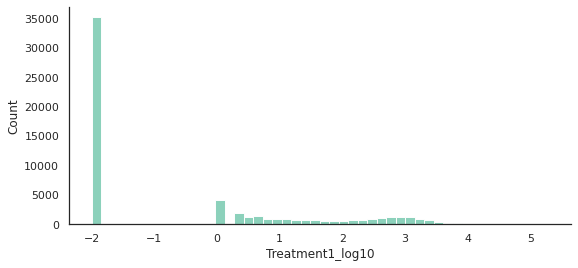

In [20]:
### Plot a control and a treament distribution of the expression values
sns.histplot(data=data, x="Treatment1_log10", multiple="stack")
sns.despine()

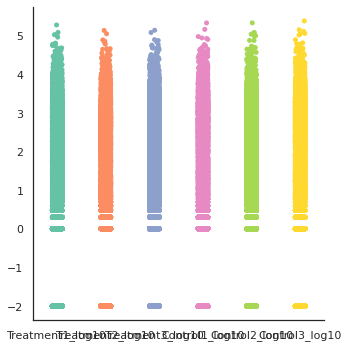

In [23]:
### Plot the log10 expression values of all samples
### What do you observe?
data_tmp=data[col_list]
sns.catplot(data=data_tmp)
sns.despine()

## DEG analysis

In [13]:
### Upload DEG analysis
deg_data = pd.read_csv("DEG_analysis_results.tsv", sep="\t", header=0)
deg_data.head()

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,ENSG00000147255,-4.212721,5.036796,-32.541174,1.016975e-07,0.001858,8.565340
1,ENSG00000151892,-2.530968,5.702625,-31.925608,1.133913e-07,0.001858,8.615486
2,ENSG00000213673,-4.730086,-2.601906,-31.415343,1.242946e-07,0.001858,5.557867
3,ENSG00000074527,1.339166,7.366807,31.234530,1.284504e-07,0.001858,8.643936
4,ENSG00000151224,-5.105304,-2.408434,-29.573299,1.753585e-07,0.001858,5.564623


In [15]:
### Explore the data
### Number of genes with significant adj.P.Values < 0.05
pval_subset = deg_data [deg_data.loc [:, "adj.P.Val"] <= 0.05]
logFC_subset = pval_subset[np.abs(pval_subset.loc[:,"logFC"])>= 3.0]

logFC_subset.shape

(114, 7)

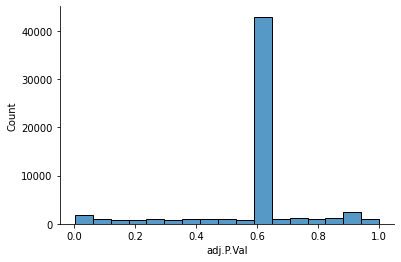

In [16]:
sns.histplot(data=deg_data, x="adj.P.Val")
sns.despine()

<AxesSubplot:xlabel='logFC', ylabel='adj.P.Val'>

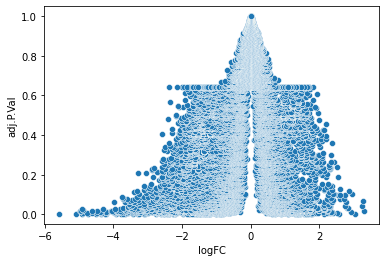

In [17]:
sns.scatterplot(data=deg_data, x="logFC", y="adj.P.Val")

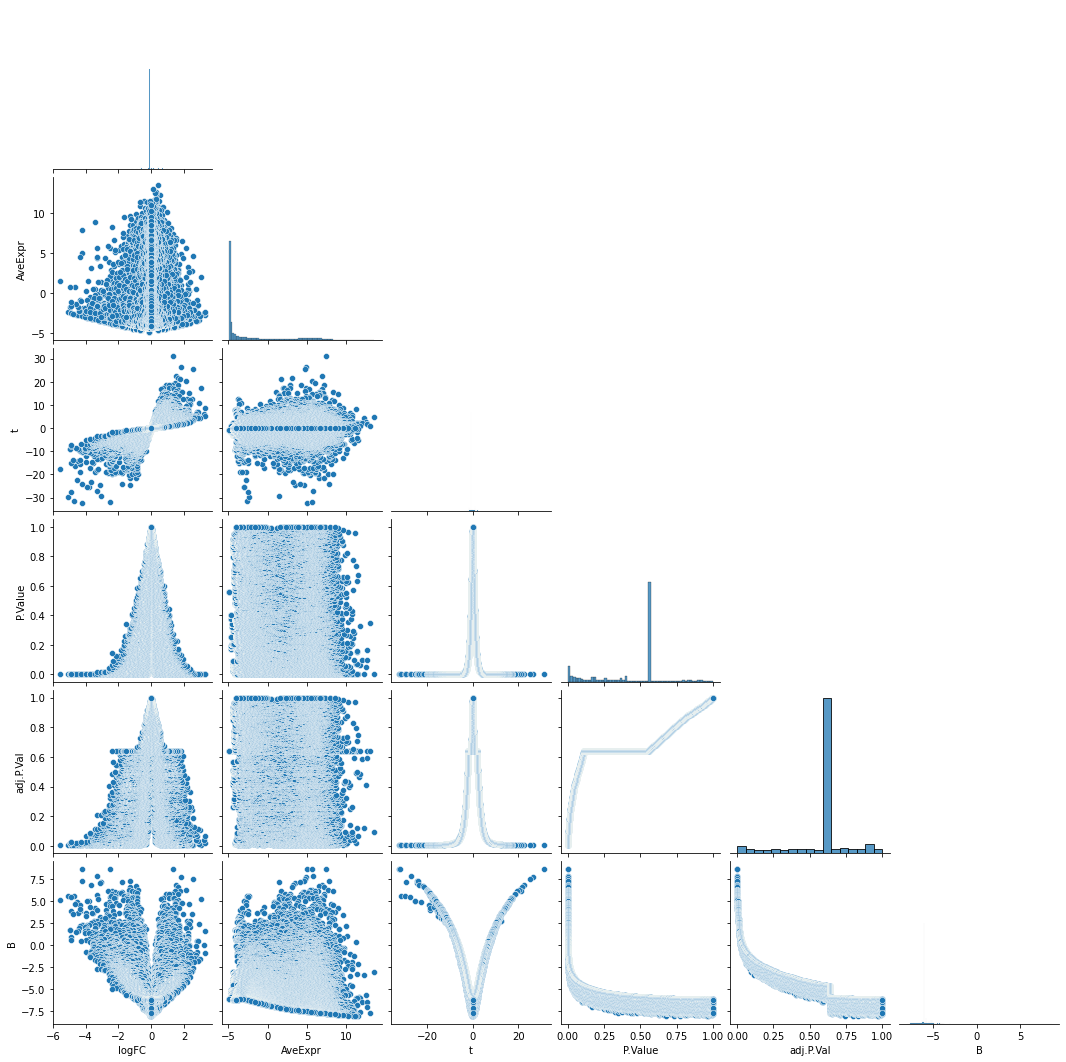

In [18]:
#Searching for interesting correlational data
p = sns.pairplot(deg_data, diag_kind="hist", corner="true")

<AxesSubplot:xlabel='logFC', ylabel='AveExpr'>

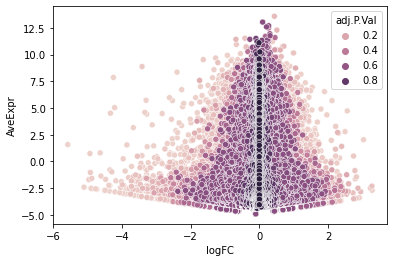

In [20]:
#average expression x logFC seems to be interesting in looking
sns.scatterplot(data=deg_data, x="logFC", y="AveExpr", hue="adj.P.Val")

<AxesSubplot:xlabel='logFC', ylabel='AveExpr'>

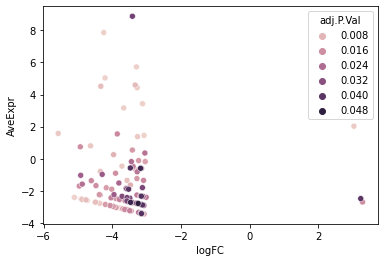

In [23]:
sns.scatterplot(data=logFC_subset, x="logFC", y="AveExpr", hue="adj.P.Val")

In [29]:
#Looking at the 2 genes that have a high average expression, low adj. P-value and low logFC
AveExpre_subset = logFC_subset[np.abs(logFC_subset.loc[:,"AveExpr"])>= 6]
AveExpre_subset.head()

,genes,logFC,AveExpr,t,P.Value,adj.P.Val,B
15,ENSG00000196208,-4.249826,7.865723,-24.012969,5.731695e-07,0.002173,7.229860
1290,ENSG00000160182,-3.415937,8.882540,-6.493501,7.645075e-04,0.035905,-0.764979


In [ ]:
### Considering the contexte, make an hypothesis
#Searching at ensembl I found out that the ENSG00000196208 gene translate the protein Growth regulation by estrogen in breast cancer.
#My hypothesis is that the treatment for breast cancer is having an effect.

In [56]:
### Confirm (or infirm your hypothesis) 
#There are different expression levels if we compare treatment and control in several genes.